In [14]:
import numpy as np 
import pandas as pd 
from river.datasets import synth
from river.datasets import AirlinePassengers, Elec2
import river.preprocessing as rpreprocessing
import river.linear_model as rlinear_model
import river.optim as roptim
from river import metrics
from river import evaluate
from river import metrics
import river.compose as rcompose
from river import multiclass
import matplotlib.pyplot as plt 

# Task 1 - Hyper-parameter tuning 

In [213]:
datastream1 = synth.RandomRBFDrift(seed_model=42, seed_sample=42, n_classes=2, n_features=10, n_centroids=20, n_drift_centroids=10, change_speed=0.1)
datastream2 = synth.LEDDrift(seed=42, noise_percentage=0.2, n_drift_features=2)
datastream3 = AirlinePassengers() # Only 144 items 
datastream4 = Elec2()

In [214]:
# Create and store the datastreams 

data1 = datastream1.take(5000)
df1 = pd.DataFrame([{**x, "class": y} for x, y in data1])

data2 = datastream2.take(5000)
df2 = pd.DataFrame([{**x, "class": y} for x, y in data2])

data3 = datastream3.take(k=144)
df3 = pd.DataFrame([{**x, "class": y} for x, y in data3])

data4 = datastream4.take(5000)
if datastream4.is_downloaded: # Check if the csv with the datastream is downloaded 
    df4 = pd.read_csv(datastream4.path) # Load the csv file into a dataframe 
else:
    df4 = pd.DataFrame([{**x, "class": y} for x, y in data4])


df3["month"] = pd.to_datetime(df3["month"])
df3["year"] = df3["month"].dt.year
df3["day"] = df3["month"].dt.day
df3["month"] = df3["month"].dt.month

df4.loc[df4["class"] == "UP", "class"] = 1
df4.loc[df4["class"] == "DOWN", "class"] = 0

df1.to_csv("./Datastreams/datastream1.csv")
df2.to_csv("./Datastreams/datastream2.csv")
df3.to_csv("./Datastreams/datastream3.csv")
df4.to_csv("./Datastreams/datastream4.csv")

In [2]:
# Load datastreams 

df1 = pd.read_csv("./Datastreams/datastream1.csv").drop('Unnamed: 0',axis=1)
df2 = pd.read_csv("./Datastreams/datastream2.csv").drop('Unnamed: 0',axis=1)
df3 = pd.read_csv("./Datastreams/datastream3.csv").drop('Unnamed: 0',axis=1)
df4 = pd.read_csv("./Datastreams/datastream4.csv").drop('Unnamed: 0',axis=1)

In [3]:
def df_to_dataset(df):
    """ Takes as an input a pandas dataframe and returns a dataset in the form of
    progressive_val_score input"""

    columns = [col for col in df.columns if col != "class"]
    dataset = []
    
    for _, row in df.iterrows():
        data =  ({col: row[col] for col in columns}, row["class"])
        dataset.append(data)
    
    return dataset

In [49]:
datasets = [df_to_dataset(df1), df_to_dataset(df2), df_to_dataset(df3), df_to_dataset(df4)]

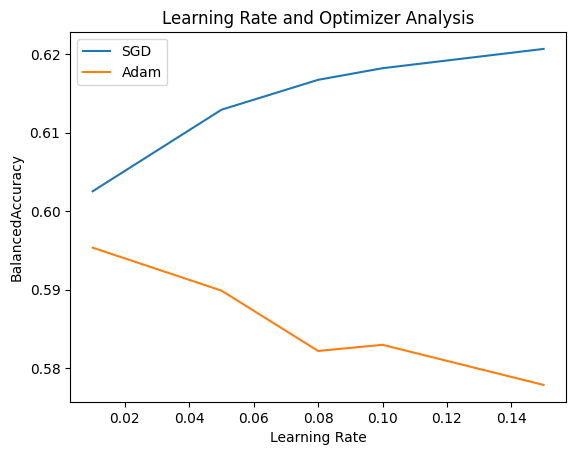

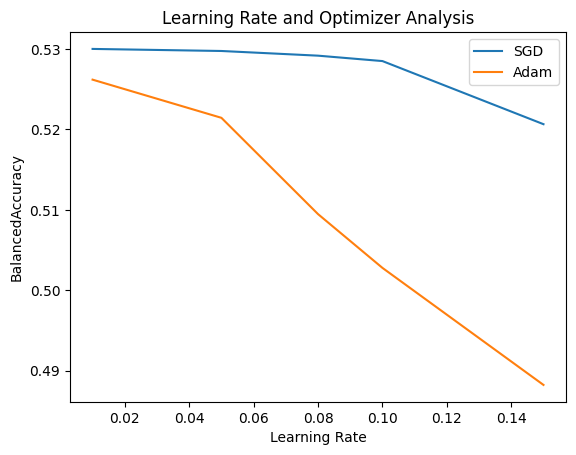

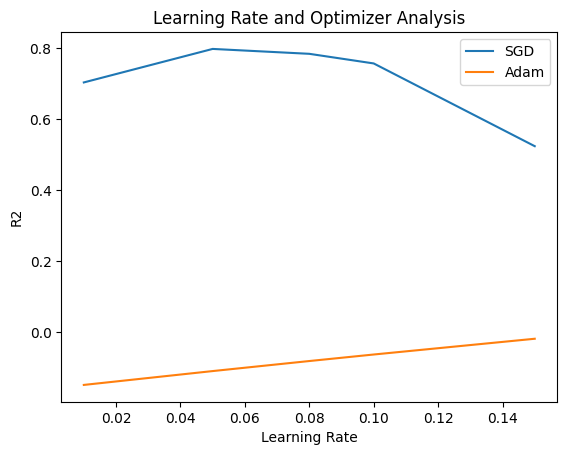

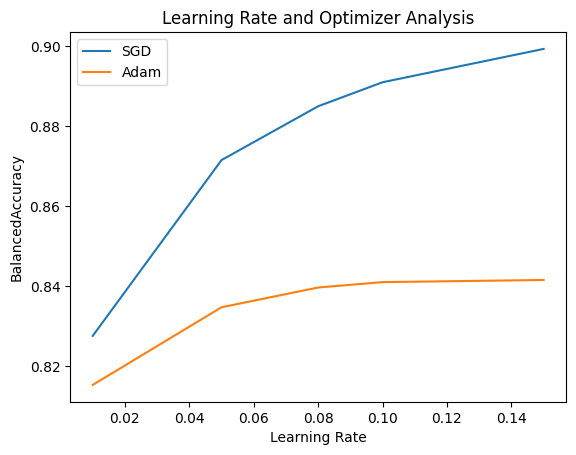

In [56]:
LEARNING_RATES = [0.01, 0.05, 0.08, 0.1, 0.15]
OPTIMIZERS = [roptim.SGD, roptim.Adam]

# Metric for classification tasks 
# Balanced accuracy : better than simply accuracy, can handle imbalanced datastreams
classification_metric = metrics.BalancedAccuracy()

# Metric for regression tasks
# Because R^2 is bounded easirerto used it for comparissons
regression_metric = metrics.R2()


for dataset in datasets:

    results = []
        
    for opt in OPTIMIZERS:
        row = []
        for lr in LEARNING_RATES:
            # For binary classification tasks (datastream 1 and datasteam 4)
            model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', rlinear_model.LogisticRegression(optimizer=opt(lr=lr))))
            
            # For regression tasks (datasteram 3)
            model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('lin_reg', rlinear_model.LinearRegression(optimizer=opt(lr=lr))))
            
            # For multiclass classification using OneVSOne approach (datastream 2)
            model3 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', multiclass.OneVsOneClassifier(rlinear_model.LogisticRegression(optimizer=opt(lr=lr)))))
            
            if dataset == datasets[0] or dataset == datasets[3]:
                model = model1
                metric =  metrics.BalancedAccuracy()
            elif dataset == datasets[2]:
                model = model2
                metric = metrics.R2()
            else:
                model = model3
                metric =  metrics.BalancedAccuracy()

            row.append(evaluate.progressive_val_score(dataset, model, metric).get())

        results.append(row)

    fig, ax = plt.subplots()
    for i in range(len(results)):
        ax.plot(LEARNING_RATES, results[i], label=OPTIMIZERS[i].__name__)

    ax.set_xlabel("Learning Rate")
    ax.set_ylabel(type(metric).__name__)
    ax.set_title("Learning Rate and Optimizer Analysis")
    ax.legend()

    plt.show()


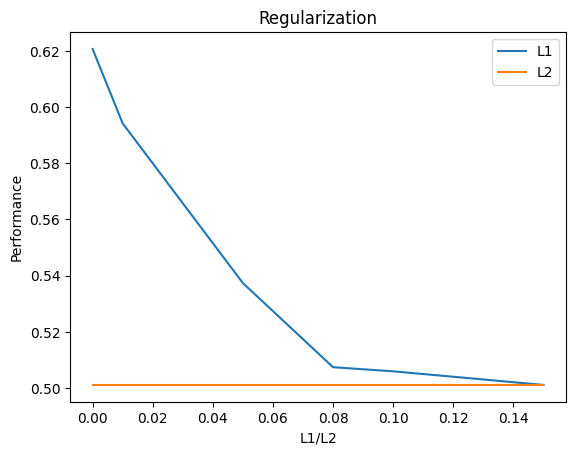

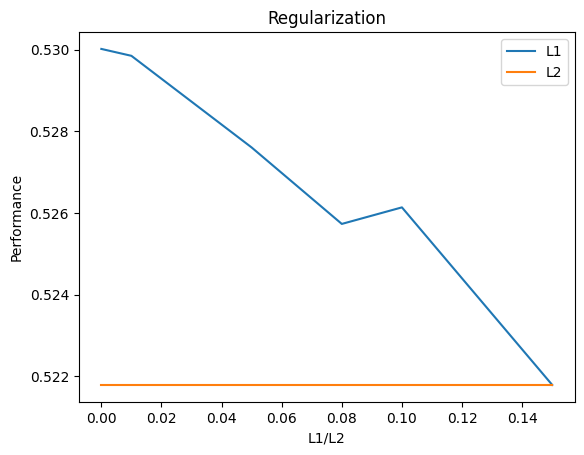

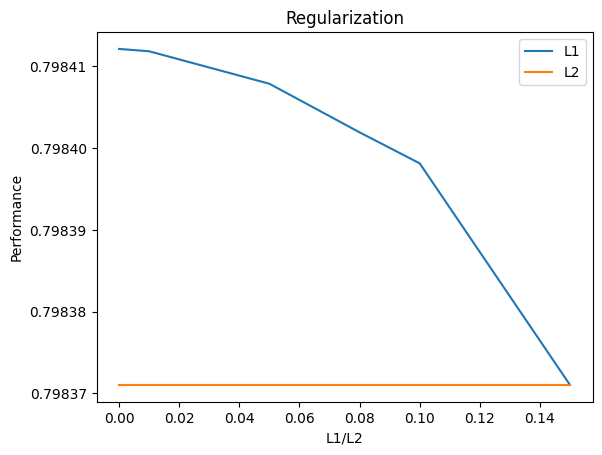

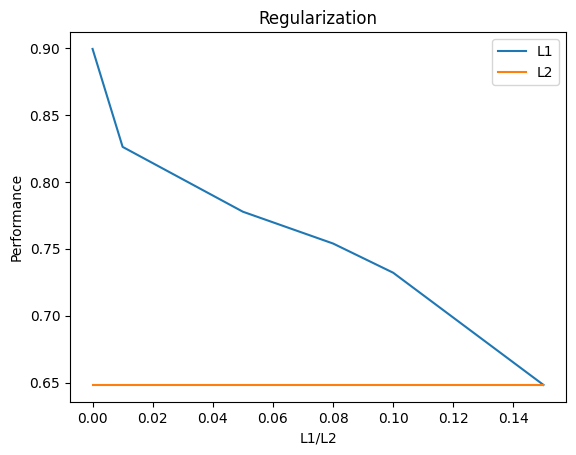

In [84]:
L1 = [0, 0.01, 0.05, 0.08, 0.1, 0.15]
L2 = [0, 0.01, 0.05, 0.08, 0.1, 0.15]

l1_results = []
l2_results = []

for l1 in L1: 
    model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.15), l1=l1)))
    
    model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('log_reg', multiclass.OneVsOneClassifier(rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.01), l1=l1))))
    
    model3 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('lin_reg', rlinear_model.LinearRegression(optimizer=roptim.SGD(lr=0.05), l1=l1)))

    model4 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.15), l1=l1)))
    
    l1_row = []
    
    l1_row.append(evaluate.progressive_val_score(datasets[0], model1, metrics.BalancedAccuracy()).get())
    l1_row.append(evaluate.progressive_val_score(datasets[1], model2, metrics.BalancedAccuracy()).get()) 
    l1_row.append(evaluate.progressive_val_score(datasets[2], model3, metrics.R2()).get()) 
    l1_row.append(evaluate.progressive_val_score(datasets[3], model4, metrics.BalancedAccuracy()).get())  

    l1_results.append(l1_row)

for l2 in L2: 
    model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.15), l2=l2)))
    
    model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('log_reg', multiclass.OneVsOneClassifier(rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.01), l2=l2))))
    
    model3 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('lin_reg', rlinear_model.LinearRegression(optimizer=roptim.SGD(lr=0.05), l2=l2)))

    model4 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.15), l2=l2)))
    
    l2_row = []
    
    l2_row.append(evaluate.progressive_val_score(datasets[0], model1, metrics.BalancedAccuracy()).get())
    l2_row.append(evaluate.progressive_val_score(datasets[1], model2, metrics.BalancedAccuracy()).get()) 
    l2_row.append(evaluate.progressive_val_score(datasets[2], model3, metrics.R2()).get()) 
    l2_row.append(evaluate.progressive_val_score(datasets[3], model4, metrics.BalancedAccuracy()).get())  

    l2_results.append(l1_row)

l1_results = np.array(l1_results)
l2_results = np.array(l2_results)

for i in range(len(datasets)):
    fig, ax = plt.subplots()
    ax.plot(L1,l1_results[:,i], label="L1")
    ax.plot(L2,l2_results[:,i], label="L2")
    ax.set_xlabel("L1/L2")
    ax.set_ylabel("Performance")
    ax.set_title("Regularization")
    ax.legend()